# Q5
We first define the data generating process for the linear IV model. 

In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import distributions as iid
import statsmodels.api as sm
from matplotlib import pyplot as plt 
from scipy.optimize import minimize_scalar

def dgp(N, beta, pi): 
    '''
    Data generating process 
    
    Input: 
    N    : # of obs 
    beta : true coefficient of x on y, scalar 
    pi   : true coefficient of Z on x, lx1 vector 
    
    Output: y, x, Z (Nxl)
    
    Assume that the residuals in both stages follow standard normal distribution and are independent. 
    '''
    l = len(pi) 
    Z = np.random.normal(size=N*l).reshape(N, l) 
    x = Z@pi + iid.norm().rvs(size=(N, 1))
    y = beta*x + iid.norm().rvs(size=(N, 1))
    return (y, x, Z)

## (1)
Here we write a function which takes as arguments $(y, x, Z, \beta_0)$ and returns the $p$-value associated with the hypothesis that each of the $l$ elements of $\hat \gamma$ is zero (with an F-test). 

In [2]:
def p_val(y, x, Z, beta0): 
    '''
    Compute p-value from an F test on \gamma = 0 
    
    Input: y, x, Z, beta0 (guess of true beta)
    
    Ouput: p-value 
    '''
    yh = y - beta0*x # transform the LHS var
    lm = sm.OLS(yh, Z).fit() # fit the linear model 
    return lm.f_pvalue # return p value from F test

## (2)
To estimate $\beta$, we start by trying possible values within $[0, 2]$ range (since we know the true $\beta = 1$). The following function returns the estimated $\beta_0$ and corresponding maximal p-value. 

In [3]:
def max_p(y, x, Z):
    '''
    Obtain the estimate beta0 that max p-value 
    
    Input: y, x, Z 
    
    Output: beta0, max p-value, CI (this is not accurate as I am only considering possible beta values in [0, 2])
    '''
    beta_lst = list(np.arange(0, 2, 0.01)) # Try beta0 in this range 
    p_lst = [] 
    
    for i in range(len(beta_lst)): # get p-value for each corresponding beta0
        p_lst.append(p_val(y, x, Z, beta_lst[i])) 
    p_dict = dict(zip(beta_lst, p_lst))
    
    max_beta = max(p_dict, key=p_dict.get)
    max_pval = p_dict[max_beta] # maxinmal pval and beta 
    
    ci_beta = list(dict(filter(lambda item: item[1]>=0.05, p_dict.items())).keys()) 
    ci = [ci_beta[0], ci_beta[-1]] # confidence interval 
    
    return max_beta, max_pval, ci

In [4]:
# def max_p(y, x, Z):
#     '''
#     Obtain the estimate beta0 that max p-value 
    
#     Input: y, x, Z 
    
#     Output: beta0, max p-value 
#     '''
#     m = minimize_scalar(lambda beta: -p_val(y, x, Z, beta))
#     return m.x, -m.fun

Taking $\pi=1$, we can estimate $\beta$ as follows. 

In [5]:
# True parameters 
N, beta, pi = 1000, 1, np.c_[1]

y, x, Z = dgp(N, beta, pi) # DGP, no set seed so each time the results will be a bit different 

b, pval, ci = max_p(y, x, Z) # estimate beta
print(f'The estimated coefficient is {b}, the corresponding maximal p-value is {pval}')

The estimated coefficient is 0.96, the corresponding maximal p-value is 0.9285338348710878


To assess the bias and precision of this estimator, we draw 1,000 random samples and plot the distribution of estiamtes. 

<function matplotlib.pyplot.show(close=None, block=None)>

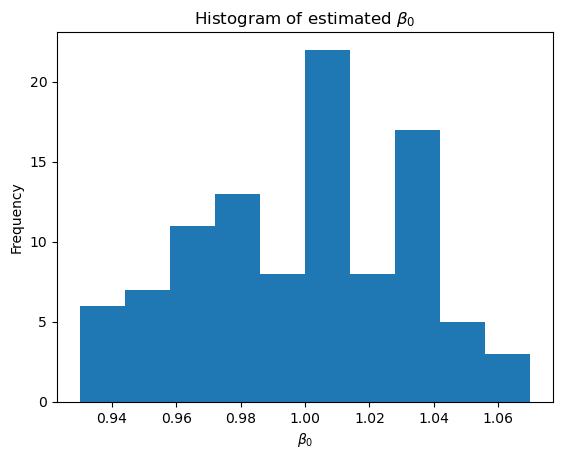

In [7]:
it = 0 
b_lst = []
while it < 100: 
    y, x, Z = dgp(N, beta, pi)
    b_lst.append(max_p(y, x, Z)[0])
    it = it + 1

plt.hist(pd.DataFrame(b_lst), )
plt.title(r'Histogram of estimated $\beta_0$')
plt.xlabel(r'$\beta_0$')
plt.ylabel('Frequency')
plt.show

As illustrated in the figure above, the estimator seems to be unbiased in expectation. Bias or deviation in a specific sample is also small, so overall it is quite precise. 

## (3)
The null hypothesis of our F test is that $\hat \gamma = 0$, which corresponds to $\beta = \beta_0$. Intuitively, to construct a 95% confidence interval on $\beta_0$, we need the p-value to be greater than or equal to 0.05 so that we cannot reject the null. The construction of confidence interval is incorporated into the 'max_p' function above. Below is another estimate from a specific sample. 

In [8]:
# True parameters 
N, beta, pi = 1000, 1, np.c_[[1, 1]]

y, x, Z = dgp(N, beta, pi) # DGP  

b, pval, ci = max_p(y, x, Z) # estimate beta
print(f'The estimated coefficient is {b}, the corresponding maximal p-value is {pval}, and confidence interval is {ci}')

The estimated coefficient is 0.99, the corresponding maximal p-value is 0.8409663794827846, and confidence interval is [0.9400000000000001, 1.04]


The 95% confidence interval from 2SLS can be obtained as follows. As a comparison, the two confidence intervals are very similar. 

In [9]:
def two_sls(y, X, Z):
    '''
    Estimate 2 stage least squares given data on y, X and Z.
    
    Inputs:
    -------
    y (Nx1 np.array)
    X (Nx1 np.array)
    Z (Nxl np.array)
    
    Returns
    -------
    beta_hat, vb_beta_hat
    '''
    y = np.array(y)
    X = np.array(X)
    Z = np.array(Z)
    ZX = np.transpose(Z)@X
    ZX_inv = np.linalg.pinv(ZX)#using pseuodo-inverse
    Zy = np.transpose(Z)@y
    ZZ = np.transpose(Z)@Z
    ZZ_inv = np.linalg.pinv(ZZ)
    #Beta_IV2SLS = ZX_inv@ZY
    beta_hat = np.linalg.pinv(np.transpose(ZX)@ZZ_inv@ZX)@(np.transpose(ZX)@ZZ_inv@Zy)
    e = y - X@beta_hat
    SSR = np.transpose(e)@e
    N = X.shape[0]
    vcv = (SSR/N)*np.linalg.pinv(np.transpose(ZX)@ZZ_inv@ZX)
    K = X.shape[1]
    se_beta_hat = np.zeros(K)
    for i in range(K):
          se_beta_hat[i] = np.sqrt(vcv[i,i])
            
    return beta_hat, se_beta_hat

In [10]:
b_2sls, se_2sls = two_sls(y, x, Z)
print(f"The estimated coefficient from 2SLS is {b_2sls[0][0]}, and the confidence interval is {b_2sls[0][0] - 1.96*se_2sls[0], b_2sls[0][0] + 1.96*se_2sls[0]}.")

The estimated coefficient from 2SLS is 0.9907994045914384, and the confidence interval is (0.9474587370473634, 1.0341400721355134).


## (4)
As $\pi$ goes from 1 toward zero, the estimate is more likely to be biased and much less precise in that it has larger standard errors. 

In [11]:
# True parameters 
for p in np.arange(1, -0.1, -0.1):
    p = np.c_[p]
    N, beta, pi = 1000, 1, p

    y, x, Z = dgp(N, beta, pi) # DGP  

    b, pval, ci = max_p(y, x, Z) # estimate beta
    print(f'\pi = {p[0]}: The estimated coefficient is {b}, the corresponding maximal p-value is {pval}, and confidence interval is {ci} \t ')

\pi = [1.]: The estimated coefficient is 1.01, the corresponding maximal p-value is 0.9025968863165359, and confidence interval is [0.96, 1.07] 	 
\pi = [0.9]: The estimated coefficient is 0.99, the corresponding maximal p-value is 0.9433370057266658, and confidence interval is [0.93, 1.06] 	 
\pi = [0.8]: The estimated coefficient is 0.96, the corresponding maximal p-value is 0.9291413504244675, and confidence interval is [0.89, 1.04] 	 
\pi = [0.7]: The estimated coefficient is 0.9400000000000001, the corresponding maximal p-value is 0.9647531286958178, and confidence interval is [0.86, 1.02] 	 
\pi = [0.6]: The estimated coefficient is 1.04, the corresponding maximal p-value is 0.9700733740975429, and confidence interval is [0.93, 1.1400000000000001] 	 
\pi = [0.5]: The estimated coefficient is 0.99, the corresponding maximal p-value is 0.9707522015079362, and confidence interval is [0.85, 1.12] 	 
\pi = [0.4]: The estimated coefficient is 1.21, the corresponding maximal p-value is 

## (5) 
The coverage of this test seems to be quite consistent even when $l$ increases from 1 to 10. 

In [12]:
seq = [(1/2)**(n) for n in range(100)]

In [19]:
for l in range(1, 101, 5): 
    p = np.c_[seq[0:l]]
    N, beta, pi = 1000, 1, p
    y, x, Z = dgp(N, beta, pi) # DGP  

    b, pval, ci = max_p(y, x, Z) # estimate beta
    print(f'# of instruments = {l}: The estimated coefficient is {b}, the corresponding maximal p-value is {pval}, and confidence interval is {ci} \t ')

# of instruments = 1: The estimated coefficient is 1.04, the corresponding maximal p-value is 0.9441763734706141, and confidence interval is [0.98, 1.11] 	 
# of instruments = 6: The estimated coefficient is 1.02, the corresponding maximal p-value is 0.819624375700069, and confidence interval is [0.9500000000000001, 1.09] 	 
# of instruments = 11: The estimated coefficient is 0.96, the corresponding maximal p-value is 0.597507112423858, and confidence interval is [0.88, 1.05] 	 
# of instruments = 16: The estimated coefficient is 0.98, the corresponding maximal p-value is 0.39206022840245675, and confidence interval is [0.9, 1.06] 	 
# of instruments = 21: The estimated coefficient is 1.02, the corresponding maximal p-value is 0.45206222160195864, and confidence interval is [0.93, 1.11] 	 
# of instruments = 26: The estimated coefficient is 1.0, the corresponding maximal p-value is 0.05219196003747301, and confidence interval is [0.99, 1.0] 	 
# of instruments = 31: The estimated coeff